In [1]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters

import tensorflow as tf
from tensorflow.keras import Model, Sequential 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D , Conv3D, Layer, MaxPooling2D, Dropout, Flatten, Dense, GRU, ConvLSTM2D, Input, BatchNormalization, TimeDistributed, MaxPooling3D, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from random import shuffle
from tensorflow.keras.regularizers import l2

# from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model, load_model


# import cv2
# import imageio
# import cv2

import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
# import IPython
# from six.moves import urllib
print(tf.__version__)
print(keras.__version__)
import pydicom
import re
import math
import random
# import bisect
np.random.seed(1234)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 1024
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 2
image_path = "/home/data/rsna-str-pulmonary-embolism-detection/train"
NUM_SCANS = 8
NUM_CHANNELS = 1
INPUT_DIM = 256


2.8.1
2.8.0
Num GPUs Available:  1


In [2]:
xs = []
ys = []

used_ids = np.load('/home/shared/nps/all_scans/convnext/ids.npy')
used_ids = used_ids.tolist()
for i in range(0, int(len(used_ids)/256)+1):
    features = np.load('/home/shared/nps/all_scans/convnext/features'+str(i)+'.npy')
    labels = np.load('/home/shared/nps/all_scans/convnext/label'+str(i)+'.npy')
    for j in range(len(features)):
        xs.append(features[j])
        ys.append(labels[j])
xs = xs[:len(used_ids)]
ys = ys[:len(used_ids)]
# np.shape(train_x), np.shape(train_y)
# train_vals = pd.DataFrame({'StudyInstanceUID':used_ids,'X': train_x,'Y':train_y})

In [3]:
used_ids = np.array(used_ids)
all_ids = pd.DataFrame({'StudyInstanceUID':used_ids[:,0], 'SeriesInstanceUID':used_ids[:,1],
                       'SOPInstanceUID':used_ids[:,2], 'features':xs, 'pe_present_on_slab':ys})

In [4]:
ids = pd.read_csv('all_ids_updated.csv')
train_ids = pd.read_csv('train_df_upd.csv').drop(columns='Unnamed: 0')
test_ids = pd.read_csv('test_df_upd.csv').drop(columns='Unnamed: 0')
val_ids = pd.read_csv('val_df_upd.csv').drop(columns='Unnamed: 0')

/tmp/ipykernel_3662786/1213750063.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  ids = pd.read_csv('all_ids_updated.csv')


In [5]:
all_ids = pd.merge(ids, all_ids, 'left')
all_ids = all_ids.dropna()
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

In [6]:
train_df = all_ids[all_ids.StudyInstanceUID.isin(train_ids.StudyInstanceUID)]
test_df = all_ids[all_ids.StudyInstanceUID.isin(test_ids.StudyInstanceUID)]
val_df = all_ids[all_ids.StudyInstanceUID.isin(val_ids.StudyInstanceUID)]

In [7]:
train_ids = train_ids[train_ids.StudyInstanceUID.isin(train_df.StudyInstanceUID)]
test_ids = test_ids[test_ids.StudyInstanceUID.isin(test_df.StudyInstanceUID)]
val_ids = val_ids[val_ids.StudyInstanceUID.isin(val_df.StudyInstanceUID)]

In [8]:
val_ids_pos = val_ids[val_ids.negative_exam_for_pe == False]
val_ids_neg = val_ids[val_ids.negative_exam_for_pe == True].sample(n=len(val_ids_pos))

train_ids_pos = train_ids[train_ids.negative_exam_for_pe == False]
train_ids_neg = train_ids[train_ids.negative_exam_for_pe == True].sample(n=len(train_ids_pos))

val_ids_sample = pd.concat([val_ids_neg, val_ids_pos])
train_ids_sample = pd.concat([train_ids_neg, train_ids_pos])

In [15]:
print(f"Total videos for training: {len(train_ids)}")
print(f"Total videos for validation: {len(val_ids)}")

num_features = 512
MAX_SEQ_LENGTH = 200


class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, study_ids, features, num_features,
                 seq_length, return_type = 'both', to_fit=True, batch_size=32, 
                 shuffle=True, resample=False, full_set = None):

        self.list_IDs = list_IDs
        self.study_ids = study_ids
        self.features = features
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_features = num_features
        self.seq_length = seq_length
        self.resample = resample
        self.full_set = full_set
        self.return_type = return_type
        warnings.filterwarnings(action='ignore')
        self.on_epoch_end()

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
#         print('starting')
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size, self.seq_length, self.num_features])
        y_seq = np.zeros([self.batch_size, self.seq_length, 1])
        y_tot = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)
            X[i] = x
            y_seq[i] = y[0]
            y_tot[i] = y[1]
            
        if self.to_fit:
            if self.return_type =='both':
                return (X, [y_seq, y_tot])
            elif self.return_type == 'seq':
                return (X, y_seq)
            elif self.return_type == 'tot':
                return (X, y_tot)
            else:
                print('valid return types are both, seq and tot')
                return False
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.resample == True:
            sample_pos = self.full_set[self.full_set.negative_exam_for_pe == False]
            sample_neg = self.full_set[self.full_set.negative_exam_for_pe == True].sample(n=len(sample_pos))
            self.study_ids = pd.concat([sample_pos, sample_neg]).sample(frac = 1).reset_index(drop=True)
        
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)
            
    def _get_scan_data(self, study_id):
        scan = self.features[self.features.StudyInstanceUID == study_id]
        scan = scan[scan.SeriesInstanceUID == scan.iloc[0].SeriesInstanceUID]
        scan = scan.sort_values(by=['ycoord'])
        
        features = scan.features.tolist()
        seq = scan.pe_present_on_slab.tolist()
        seq = np.array(seq) > 1
        tot = scan.negative_exam_for_pe.iloc[0]
        
        if len(features)>=self.seq_length:
            inst = np.round(np.linspace(0,len(features)-1,self.seq_length)).astype(int)
            xs = (np.array(features)[inst]).tolist()
            ys = seq[inst]
        else:
            xs = np.zeros([self.seq_length, self.num_features])
            ys = np.zeros([self.seq_length, 1])
            
            xs[:len(features)] = features
            ys[:len(features)] = seq
        
        ys = ys.tolist()
        
        return (xs, [ys, tot])





training_generator = DataGenerator(np.arange(0,len(train_ids_sample)), train_ids_sample,train_df, num_features, MAX_SEQ_LENGTH, resample=True, full_set=train_ids, batch_size = 2)
validation_generator = DataGenerator(np.arange(0,len(val_ids_sample)), val_ids_sample,val_df, num_features, MAX_SEQ_LENGTH, batch_size = 2)
test_generator = DataGenerator(np.arange(0,len(test_ids)), test_ids, num_features, test_df, MAX_SEQ_LENGTH, batch_size = 2)

# x,y = training_generator.__getitem__(0)
# np.shape(x)

Total videos for training: 5321
Total videos for validation: 672


In [26]:
import gc
import datetime
tf.keras.backend.clear_session()
gc.collect()

def get_gru_model():
    sequence_length = MAX_SEQ_LENGTH
    features_dim = 512
    gru_dim = 128
    embed_dim = gru_dim*2
    dense_dim = 8
    num_heads = 4
    classes = 1
    
    inputs = keras.Input(shape=(sequence_length, features_dim))
    
    x = Bidirectional(keras.layers.GRU(gru_dim, return_sequences=True))(inputs)
#     x = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.6)(x,x)

#     x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
#     x = TimeDistributed(keras.layers.Dropout(0.5))(x)
    
#     x = PositionalEmbedding(
#         sequence_length, embed_dim, name="frame_position_embedding")(x)
#     x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
        
    x = MultiHeadAttention(num_heads=2, key_dim=32, dropout=0.4)(x,x)
#     x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
#     x = TimeDistributed(keras.layers.Dropout(0.5))(x)
    
    x = TimeDistributed(layers.Dense(64, activation='relu'))(x)
    x = TimeDistributed(keras.layers.Dropout(0.4))(x)
    
    x = keras.layers.GRU(32, dropout=0.4)(x)
    
#     x = keras.layers.Dense(32, activation="relu")(x)
#     x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    rnn_model = keras.Model(inputs, output)

    rnn_model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
        optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01),
        loss="binary_crossentropy", 
        metrics=["accuracy",]
    )
    return rnn_model


model = get_gru_model()
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/attention_gru4'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=30,
    batch_size = 1,
#     validation_split = 0.15
    callbacks=[checkpoint],
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 512)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 256)     493056      ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 200, 256)    65984       ['bidirectional[0][0]',          
 dAttention)                                                      'bidirectional[0][0]']          
                                                                                                  
 time_distributed (TimeDistribu  (None, 200, 64)     16448       ['multi_head_attention[0][0]'

2022-09-27 14:48:33.201512: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (153,) + inhomogeneous part.
Traceback (most recent call last):

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data i

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (153,) + inhomogeneous part.
Traceback (most recent call last):

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_3662786/1552856302.py", line 49, in __getitem__
    x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)

  File "/tmp/ipykernel_3662786/1552856302.py", line 96, in _get_scan_data
    xs[:len(features)] = features

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (153,) + inhomogeneous part.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[model/bidirectional/forward_gru/Shape/_2]]
  (1) INVALID_ARGUMENT:  ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (153,) + inhomogeneous part.
Traceback (most recent call last):

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "/home/jupyter-paige/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 956, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_3662786/1552856302.py", line 49, in __getitem__
    x, y = self._get_scan_data(self.study_ids.iloc[indexes[i]].StudyInstanceUID)

  File "/tmp/ipykernel_3662786/1552856302.py", line 96, in _get_scan_data
    xs[:len(features)] = features

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (153,) + inhomogeneous part.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_82586]

In [25]:
def get_gru_model():
    sequence_length = MAX_SEQ_LENGTH
    features_dim = 512
    gru_dim = 64
    embed_dim = gru_dim*2
    dense_dim = 8
    num_heads = 4
    classes = 1
    
    inputs = keras.Input(shape=(sequence_length, features_dim))
    
    x = Bidirectional(keras.layers.GRU(gru_dim, return_sequences=True))(inputs)
    x = TimeDistributed(layers.Dense(32, activation='relu'))(x)
    x = TimeDistributed(keras.layers.Dropout(0.6))(x)   
    x = keras.layers.GRU(int(gru_dim/4), dropout=0.4, return_sequences=True)(x)
    x = MultiHeadAttention(num_heads=2, key_dim=32, dropout=0.4)(x,x)
    x = keras.layers.GlobalMaxPooling1D()(x)
#     x = keras.layers.Dropout(0.6)(x)
#     x = keras.layers.Dense(16, activation="relu")(x)
    x = keras.layers.Dropout(0.9)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)

    rnn_model = keras.Model(inputs, output)

    rnn_model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
        optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01),
        loss="binary_crossentropy", 
        metrics=["accuracy",]
    )
    return rnn_model


model = get_gru_model()
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/attention_gru7'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    batch_size = 1,
#     validation_split = 0.15
    callbacks=[checkpoint],
)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 200, 512)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 128)     221952      ['input_12[0][0]']               
                                                                                                  
 time_distributed (TimeDistribu  (None, 200, 32)     4128        ['bidirectional[0][0]']          
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 200, 32)     0           ['time_distributed[0][0]'] 

KeyboardInterrupt: 

In [169]:
def get_turku_lstm(seq_len, dim):
        inputs = keras.Input(shape=(seq_len, dim))
        x = layers.BatchNormalization()(inputs)
        x = layers.Bidirectional(layers.LSTM(units=64, return_sequences=True))(x)
        x = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
        x = layers.TimeDistributed(layers.Dense(32, activation='relu'))(x)
        slice_outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
        
        reshaped_features = layers.Reshape((seq_len,))(slice_outputs)
#         reshaped_features = layers.Dropout(0.05)(reshaped_features)
        stack_outputs = layers.Dense(1, activation='sigmoid', name='sequence')(reshaped_features)
        
        model = keras.models.Model(inputs=inputs, outputs=[slice_outputs, stack_outputs])
        
        return model

In [17]:
train_ids_sample = train_ids_sample.sample(frac=1)

training_generator = DataGenerator(np.arange(0,len(train_ids_sample)), 
                                   train_ids_sample,
                                   train_df, 
                                   num_features, 
                                   200, 
                                   resample=True, 
                                   full_set=train_ids, 
                                   return_type='tot',
                                   batch_size = 1)
validation_generator = DataGenerator(np.arange(0,len(val_ids_sample)), 
                                     val_ids_sample,
                                     val_df, 
                                     num_features, 
                                     200,
                                     return_type='tot',
                                     batch_size = 1)
test_generator = DataGenerator(np.arange(0,len(test_ids)), 
                               test_ids, 
                               num_features, 
                               test_df, 
                               200, 
                               return_type='tot',
                               batch_size = 1)



In [ ]:
model = get_turku_lstm(200,512)
model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss="binary_crossentropy", 
        metrics=["accuracy",]
    )

model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/turku'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    batch_size = 1,
#     validation_split = 0.15
    callbacks=[checkpoint],
)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 200, 512)]        0         
                                                                 
 batch_normalization_19 (Bat  (None, 200, 512)         2048      
 chNormalization)                                                
                                                                 
 bidirectional_17 (Bidirecti  (None, 200, 128)         295424    
 onal)                                                           
                                                                 
 time_distributed_51 (TimeDi  (None, 200, 128)         16512     
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 200, 32)          4128      
 stributed)                                               

In [24]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
    ):
    
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


input_shape = [200,512]

model = build_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=2,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

checkpoint_filepath = '/home/shared/model_checkpoint_paige/scan/transformer'
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_weights_only=True, save_best_only=True, verbose=1
)
# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs=10,
    batch_size=1,
    callbacks=[checkpoint],
)

model.evaluate(x_test, y_test, verbose=1)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 200, 512)]   0           []                               
                                                                                                  
 layer_normalization_54 (LayerN  (None, 200, 512)    1024        ['input_11[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_28 (Multi  (None, 200, 512)    2100736     ['layer_normalization_54[0][0]', 
 HeadAttention)                                                   'layer_normalization_54[0][0]'] 
                                                                                            

KeyboardInterrupt: 

In [143]:
model.load_weights(checkpoint_filepath)
model.evaluate(validation_generator)

202/202 [==============================] - 3s 13ms/step - loss: 0.6074 - accuracy: 0.7005


[0.6073625683784485, 0.7004950642585754]

In [136]:
x = tf.convert_to_tensor(val_vals.X.to_list())
y = np.reshape(val_vals.Y.astype('float').to_list(), [405])

In [137]:
pred = model.predict(x)

In [142]:
(131+153)/(131+71+50+153)

0.7012345679012346

In [154]:
from sklearn.metrics import confusion_matrix

# pred = pred - 0.03
cm = confusion_matrix(y, pred.round())
cm

array([[131,  71],
       [ 50, 153]])

In [145]:
153/203

0.7536945812807881

In [160]:
cm[1,1]/(cm[1,0]+cm[1,1])

0.7536945812807881

In [162]:
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity, sensitivity

(0.7536945812807881, 0.6485148514851485)

In [124]:
y.sum()

203.0

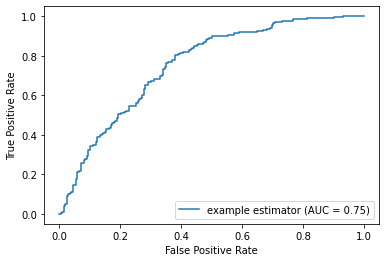

In [164]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()